In [127]:
import cv2
import yaml
from ultralytics import YOLO
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
class VideoProcessor:
        
    def __init__(self, sign_model_path, traffic_light_model_url, sign_classes_yaml):
        """
        Инициализация класса для обработки видео с использованием моделей для распознавания знаков и светофоров.
        
        :param sign_model_path: Путь к файлу модели для распознавания знаков (YOLO).
        :param traffic_light_model_url: Ссылка на модель для распознавания светофоров.
        :param sign_classes_yaml: Путь к файлу в формате YAML, который содержит классы знаков.
        :param lane_detection_algo_path: Путь к алгоритму для распознавания разметки (пока не реализовано).
        """
        self.sign_model = YOLO(sign_model_path)
        self.traffic_light_model = YOLO(traffic_light_model_url)
        self.traffic_signs = {"2.5": "Движение без остановки запрещено", "1.12": "Разметка стоп-линия", "5.15.1": "Полоса для маршрутных транспортных средств", "5.15.2": "Полоса для маршрутных транспортных средств", "3.1": "Въезд запрещен (кирпич)", "1.4.1": "Обозначение полос движения", "4.1.1": "Движение прямо", "2.1": "Главная дорога", "3.27": "Остановка запрещена", "3.28": "Стоянка запрещена", "3.18.1": "Поворот налево запрещен", "3.18.2": "Разворот запрещен", "4.1.3": "Движение налево", "3.20": "Обгон запрещен", "1.1": "Сплошная линия разметки"}
          
    def process_traffic_lights_and_stop_signs(self, frame, confidence=0.25):
        """
        Функция для обработки кадра и распознавания светофоров и стоп-знаков.
        
        :param frame: Входной кадр для обработки.
        :return: Список с координатами для светофоров и стоп-знаков.
        """
        results = self.traffic_light_model(frame)
        boxes = results[0].boxes.xywh.tolist()
        cls = results[0].boxes.cls.tolist()
        conf = results[0].boxes.conf
        bboxes_traffic_lights = []
        bboxes_stop_signs = []
        traffic_lights_colors = []

        # Проходим по всем найденным объектам и определяем их тип
        for (box, cls_, conf_) in zip(boxes, cls, conf):  # Перебор объектов

            x, y, w, h = box
            class_name = results[0].names[int(cls_)]
            if conf_ > confidence:
                if class_name.lower() == 'traffic light':  # Если это светофор
                    bboxes_traffic_lights.append((x, y, w, h))
                    traffic_lights_colors.append(self.crop_and_identify_color(frame, box))
                elif class_name.lower() == 'stop sign':  # Если это стоп-знак
                    bboxes_stop_signs.append((x, y, w, h))
        
        return bboxes_traffic_lights, traffic_lights_colors, bboxes_stop_signs
    
    def crop_and_identify_color(self, frame, bbox):
        """
        Обрезает изображение по координатам bounding box и определяет цвет светофора.

        :param frame: Исходное изображение (кадр) для обработки.
        :param bbox: Координаты bounding box в формате (x, y, w, h), где x и y - координаты центра, 
                    w и h - ширина и высота.
        :return: Целочисленное значение, обозначающее преобладающий цвет:
                1 - красный или желтый (сигналы, означающие остановку),
                0 - зеленый (сигнал продолжения движения),
                None - цвет не определен.
        """
        # bbox — координаты в формате (x, y, w, h)
        x, y, w, h = bbox

        # Определение верхнего левого и нижнего правого углов
        x1 = int(x - w / 2)
        y1 = int(y - h / 2)
        x2 = int(x + w / 2)
        y2 = int(y + h / 2)

        # Обрезка изображения по заданным координатам
        cropped_image = frame[y1:y2, x1:x2]

        # Преобразование в цветовое пространство HSV
        hsv_cropped = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2HSV)

        # Определение диапазонов цвета для красного, желтого и зеленого
        red_lower1 = np.array([0, 70, 50])
        red_upper1 = np.array([10, 255, 255])
        red_lower2 = np.array([170, 70, 50])
        red_upper2 = np.array([180, 255, 255])
        green_lower = np.array([35, 70, 50])
        green_upper = np.array([85, 255, 255])
        yellow_lower = np.array([20, 70, 50])
        yellow_upper = np.array([30, 255, 255])

        # Маски для определения цветов
        mask_red = cv2.inRange(hsv_cropped, red_lower1, red_upper1) + cv2.inRange(hsv_cropped, red_lower2, red_upper2)
        mask_green = cv2.inRange(hsv_cropped, green_lower, green_upper)
        mask_yellow = cv2.inRange(hsv_cropped, yellow_lower, yellow_upper)

        # Подсчет количества пикселей каждого цвета
        red_count = np.sum(mask_red > 0)
        green_count = np.sum(mask_green > 0)
        yellow_count = np.sum(mask_yellow > 0)

        # Определение преобладающего цвета
        if red_count > green_count and red_count > yellow_count:
            return 1
        elif green_count > red_count and green_count > yellow_count:
            return 0
        elif yellow_count > red_count and yellow_count > green_count:
            return 1
        else:
            return 0
    
    def draw_annotations(self, frame, results:dict):
        """
        Рисует аннотации на изображении на основе результатов распознавания объектов.

        :param frame: Кадр изображения, на котором будут отображаться аннотации.
        :param results: Словарь с результатами распознавания, где ключи — метки объектов, 
                        а значения — списки координат их bounding boxes.
                        Формат словаря: {'label1': [(x1, y1, w1, h1), ...], 'label2': [(x2, y2, w2, h2), ...], ...}
        
        Описание:
        - Функция проходит по всем меткам и их bounding boxes в словаре результатов и рисует их на изображении.
        - Рисует прямоугольники вокруг обнаруженных объектов и отображает метки классов рядом с ними.
        """
        for label, bboxes in results.items():
            for x, y, w, h in bboxes:
                cv2.rectangle(frame, (int(x - w / 2), int(y - h / 2)),
                            (int(x + w / 2), int(y + h / 2)), (0, 255, 0), 2)
                # Отображаем метку класса рядом с bbox
                cv2.putText(frame, label, (int(x - w / 2), int(y - h / 2) - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                plt.imshow(frame)
                plt.show()

In [129]:
proc = VideoProcessor('D:\\traffic_violation_checker\\models\\best.pt', 'D:\\traffic_violation_checker\\models\\yolov8s.pt', 'D:\\traffic_violation_checker\\models\\class_labels.yaml')

In [130]:
#загрузим тестовое изображение
image = cv2.cvtColor(cv2.imread('D:\\traffic_violation_checker\\data\\img\\example4.png'), cv2.COLOR_BGR2RGB)

In [131]:
image_proc = { 'traffic_light': (proc.process_traffic_lights_and_stop_signs(image))[0]}


0: 256x640 14 cars, 1 traffic light, 141.7ms
Speed: 7.6ms preprocess, 141.7ms inference, 16.0ms postprocess per image at shape (1, 3, 256, 640)


In [132]:
proc.process_traffic_lights_and_stop_signs(image)


0: 256x640 14 cars, 1 traffic light, 122.4ms
Speed: 3.0ms preprocess, 122.4ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)


([(1289.59375, 138.89096069335938, 44.7630615234375, 118.78851318359375)],
 [1],
 [])

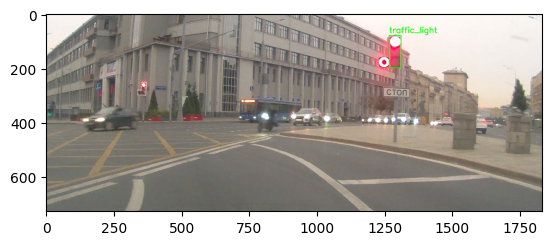

In [133]:
proc.draw_annotations(image, image_proc)


0: 320x640 1 traffic light, 144.7ms
Speed: 5.5ms preprocess, 144.7ms inference, 2.2ms postprocess per image at shape (1, 3, 320, 640)
[1]


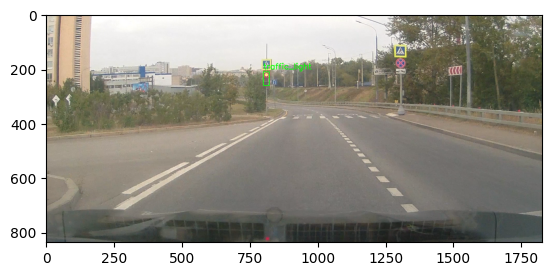

In [134]:
#загрузим тестовое изображение
image = cv2.cvtColor(cv2.imread('D:\\traffic_violation_checker\\data\\img\\example5.png'), cv2.COLOR_BGR2RGB)
image_proc = { 'traffic_light': (temp_ := proc.process_traffic_lights_and_stop_signs(image))[0]}
print(temp_[1])
proc.draw_annotations(image, image_proc)


0: 320x640 6 cars, 2 trucks, 1 traffic light, 144.2ms
Speed: 2.0ms preprocess, 144.2ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)
[1]


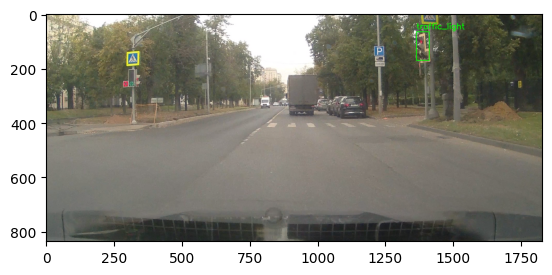

In [135]:
#загрузим тестовое изображение
image = cv2.cvtColor(cv2.imread('D:\\traffic_violation_checker\\data\\img\\example6.png'), cv2.COLOR_BGR2RGB)
image_proc = { 'traffic_light': (temp_ := proc.process_traffic_lights_and_stop_signs(image))[0]}
print(temp_[1])
proc.draw_annotations(image, image_proc)

In [136]:
#загрузим тестовое изображение
image = cv2.cvtColor(cv2.imread('D:\\traffic_violation_checker\\data\\img\\example7.jpg'), cv2.COLOR_BGR2RGB)
image_proc = { 'traffic_light': (temp_ := proc.process_traffic_lights_and_stop_signs(image))[0]}
print(temp_[1])
proc.draw_annotations(image, image_proc)


0: 480x640 2 cars, 176.3ms
Speed: 4.5ms preprocess, 176.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
[]



0: 480x640 1 person, 7 cars, 3 traffic lights, 187.0ms
Speed: 5.0ms preprocess, 187.0ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)
[0, None, 1]


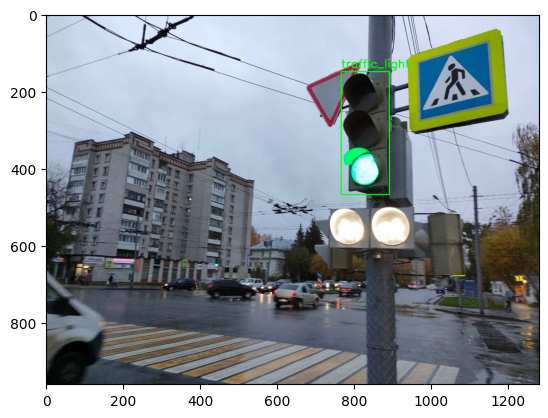

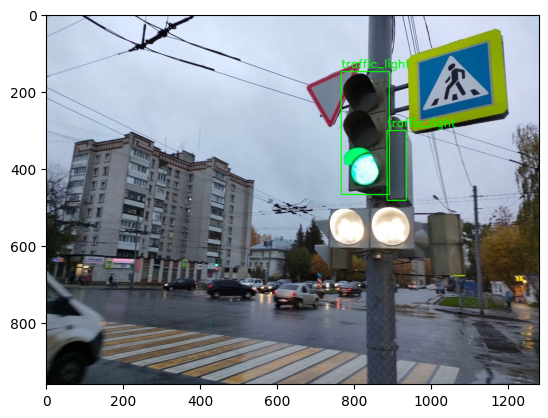

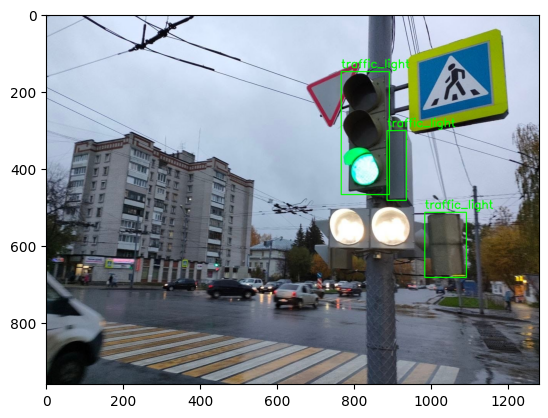

In [137]:
#загрузим тестовое изображение
image = cv2.cvtColor(cv2.imread('D:\\traffic_violation_checker\\data\\img\\example8.jpg'), cv2.COLOR_BGR2RGB)
image_proc = { 'traffic_light': (temp_ := proc.process_traffic_lights_and_stop_signs(image))[0]}
print(temp_[1])
proc.draw_annotations(image, image_proc)